In [31]:
# simple base case
# ROC curve XGboost out of the box, lightboost, catboost

# problem
# x% defaults
# on average default costs us is x
# on average lifetime value of a customer is x
# baseline 0 dollars

# baseline model
# application only
# make labels, categorize, minimal scrubbing
# roc curve, $

# engineered features
# previous aaplication
# credit history
# tune xgboost
# roc curve, $

# further things to do
# preprocessing, suspect we can throw more anomalies out
# feature engineering - 
#  - just dumped the tables, did some ratios, so should review thoroughly
#  - more ratios, polynomial features, cleaner labels
#  - can probably delete many features
#  - review winning solutions, sounds like they have some automated tools for trying many feautres
# class imbalance - resampling
# stack/ensemble models

import warnings
import pickle
from itertools import product

# time in seconds
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set()

# XGBoost https://xgboost.readthedocs.io/en/latest/
# conda install -c conda-forge xgboost
import xgboost 
from xgboost import XGBClassifier
from xgboost import plot_importance

# Microsoft LightGbm https://lightgbm.readthedocs.io/en/latest/
# conda install -c conda-forge lightgbm
import lightgbm as lgb 

# Yandex CatBoost https://catboost.yandex/
# conda install -c conda-forge catboost
import catboost 
from catboost import CatBoostClassifier

random_state = 42

from time import strftime, localtime
print("Start: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))


Start: Oct 28 2018 13:25:38


In [32]:
data = pd.read_pickle("subsample2.pickle")
data.head()


,TARGET,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,BASEMENTAREA_AVG,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,1,100002,24700.5,406597.5,202500.0,0.000000,0.000000,1.000000,0.024700,0.036900,...,1,0,0,0,0,0,0,0,0,1
1,0,100003,35698.5,1293502.5,270000.0,0.000000,0.000000,0.000000,0.095900,0.052900,...,0,0,0,0,1,0,0,0,0,0
2,0,100004,6750.0,135000.0,67500.0,0.000000,0.000000,0.000000,0.118138,0.088673,...,0,0,1,0,1,0,0,0,0,0
3,0,100006,29686.5,312682.5,135000.0,0.231697,0.304399,1.911564,0.118138,0.088673,...,0,0,1,0,0,0,0,0,0,1
4,0,100007,21865.5,513000.0,121500.0,0.000000,0.000000,0.000000,0.118138,0.088673,...,0,0,1,0,0,0,0,1,0,0


In [33]:
list(data.columns)

['TARGET',
 'SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'COMMONAREA_AVG',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'HOUR_APPR_PROCESS_START',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'OWN_CAR_AGE',
 'RATE_ANNUITY_INCOME',
 'RATE_CREDIT_EXT1',
 'RATE_CREDIT_EXT2',
 'RATE_CREDIT_EXT3',
 'RATE_CREDIT_INCOME',
 'RATE_CREDIT_VALUE',
 'RATE_INCOME_EXT1',
 'RATE_INCOME_EXT2',
 'RATE_INCOME_EXT3',
 'RATE_PAYMENT_CREDIT',
 'RATE_PAYMENT_EXT1',
 'RATE_PAYMENT_EXT2',
 'RATE_PAYMENT_EXT3',
 'REGION_POP

In [34]:
# predictors : cols 2 to end
X = data.iloc[:,2:].astype(float)
#X = data.values[:,2:].astype(float)
# response: col 1
y = data["TARGET"].astype(float)


In [35]:
# first categorical col
first_categorical_column = 49
nrows, ncols = X.shape
data.iloc[:10,first_categorical_column+2:first_categorical_column+6]

,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0
6,1,0,0,0
7,1,0,0,0
8,1,0,0,0
9,1,0,0,0


In [36]:
X.iloc[:10,first_categorical_column:first_categorical_column+4]


,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0


In [37]:
X_train, X_xval, y_train, y_xval = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [38]:
y_train

181648    0.0
229245    0.0
122525    1.0
306311    1.0
300658    0.0
201033    0.0
86445     0.0
225267    0.0
42927     0.0
240820    0.0
193691    0.0
190669    0.0
270875    0.0
97464     0.0
283993    0.0
23750     0.0
124306    0.0
28423     0.0
252183    0.0
39941     0.0
115584    0.0
29456     0.0
37475     0.0
148624    0.0
264008    0.0
279203    0.0
108065    0.0
115746    0.0
247351    1.0
246       1.0
         ... 
60759     0.0
234644    0.0
3487      0.0
88178     0.0
128969    0.0
30712     0.0
279566    1.0
26201     0.0
203798    0.0
177502    0.0
23286     1.0
70057     0.0
258456    0.0
163675    0.0
148573    0.0
304722    0.0
288987    0.0
232332    0.0
58959     0.0
234985    0.0
282761    0.0
269123    0.0
255356    0.0
222225    1.0
170183    0.0
31304     0.0
121193    0.0
248504    0.0
175469    1.0
285162    0.0
Name: TARGET, Length: 246008, dtype: float64

In [39]:
%%time
model = XGBClassifier() # baseline defaults
model.fit(X_train, y_train)
print("done")

done
CPU times: user 2min 45s, sys: 1.37 s, total: 2min 46s
Wall time: 2min 46s


In [40]:
# find threshold that gives best f_score
def best_f1_thresh(y_true, y_pred_proba):
    # get ROC curve thresholds
    precision, recall, thresholds = precision_recall_curve(y_xval, y_pred_proba)
    # compute f1 at each threshold
    f1_scores = [2*p*r/(p+r) for p, r in zip(precision, recall)]
    return thresholds[np.argmax(f1_scores)]

# predict probability
y_pred_xval_proba = model.predict_proba(X_xval)[:,1]
# pick threshold for best f1
thresh = best_f1_thresh(y_xval, y_pred_xval_proba)
# make binary prediction
y_pred_xval = y_pred_xval_proba >= thresh

print("Precision:      %.03f" % precision_score(y_xval, y_pred_xval))
print("Recall:         %.03f" % recall_score(y_xval, y_pred_xval))
print("F1:             %.03f" % f1_score(y_xval, y_pred_xval))
print("Accuracy:       %.03f" % accuracy_score(y_xval, y_pred_xval))
print("AUC:            %.03f" % roc_auc_score(y_score=y_pred_xval_proba,y_true=y_xval))

print(confusion_matrix(y_xval, y_pred_xval))

Precision:      0.253
Recall:         0.411
F1:             0.313
Accuracy:       0.854
AUC:            0.759
[[50512  6026]
 [ 2923  2042]]


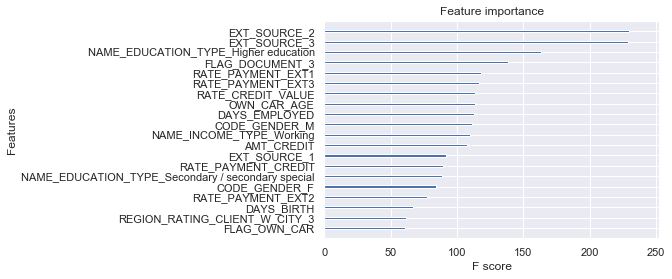

In [41]:
plot_importance(model,importance_type='gain', show_values=False, max_num_features=20);


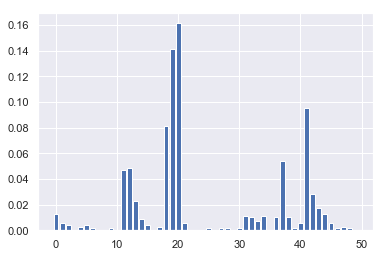

In [42]:
howmany = 50
plt.bar(range(howmany), model.feature_importances_[:howmany])
plt.show()

In [43]:
predictor_names = list(data.columns)[1:]
pd.DataFrame(list(zip(predictor_names,model.feature_importances_[:howmany]))).sort_values(1, ascending=False)

,0,1
20,EXT_SOURCE_2,0.161429
19,EXT_SOURCE_1,0.141429
41,RATE_INCOME_EXT3,0.095714
18,ENTRANCES_AVG,0.081429
37,RATE_CREDIT_INCOME,0.054286
12,DAYS_BIRTH,0.048571
11,COMMONAREA_AVG,0.047143
42,RATE_PAYMENT_CREDIT,0.028571
13,DAYS_EMPLOYED,0.022857
43,RATE_PAYMENT_EXT1,0.017143


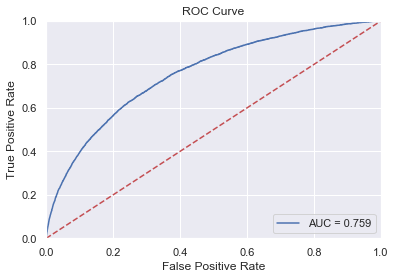

In [44]:
def plot_roc_curve(y_xval, y_pred):
    fpr, tpr, threshold = roc_curve(y_xval, y_pred)
    roc_auc = auc(fpr, tpr)


    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show();
    
plot_roc_curve(y_xval, y_pred_xval_proba)

In [46]:
first_categorical_column
categorical_features = list(range(first_categorical_column,ncols))


In [47]:
# lightgbm 
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_xval, label=y_xval)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

In [48]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = lgb.train(parameters,
                      train_data,
                      valid_sets=test_data,
                      num_boost_round=5000,
                      early_stopping_rounds=100)

print("done")

[1]	valid_0's auc: 0.71355
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.725438
[3]	valid_0's auc: 0.728849
[4]	valid_0's auc: 0.731197
[5]	valid_0's auc: 0.733592
[6]	valid_0's auc: 0.733969
[7]	valid_0's auc: 0.735673
[8]	valid_0's auc: 0.736888
[9]	valid_0's auc: 0.738061
[10]	valid_0's auc: 0.738683
[11]	valid_0's auc: 0.74089
[12]	valid_0's auc: 0.741818
[13]	valid_0's auc: 0.743971
[14]	valid_0's auc: 0.744799
[15]	valid_0's auc: 0.745506
[16]	valid_0's auc: 0.746185
[17]	valid_0's auc: 0.746779
[18]	valid_0's auc: 0.747666
[19]	valid_0's auc: 0.747767
[20]	valid_0's auc: 0.747921
[21]	valid_0's auc: 0.748211
[22]	valid_0's auc: 0.748494
[23]	valid_0's auc: 0.748569
[24]	valid_0's auc: 0.748976
[25]	valid_0's auc: 0.749403
[26]	valid_0's auc: 0.749574
[27]	valid_0's auc: 0.749777
[28]	valid_0's auc: 0.749958
[29]	valid_0's auc: 0.750187
[30]	valid_0's auc: 0.75032
[31]	valid_0's auc: 0.750536
[32]	valid_0's auc: 0.750825
[33]	valid_0's auc: 0

[277]	valid_0's auc: 0.766944
[278]	valid_0's auc: 0.76695
[279]	valid_0's auc: 0.766931
[280]	valid_0's auc: 0.76693
[281]	valid_0's auc: 0.766895
[282]	valid_0's auc: 0.766906
[283]	valid_0's auc: 0.766894
[284]	valid_0's auc: 0.766911
[285]	valid_0's auc: 0.766847
[286]	valid_0's auc: 0.766862
[287]	valid_0's auc: 0.766929
[288]	valid_0's auc: 0.76691
[289]	valid_0's auc: 0.766868
[290]	valid_0's auc: 0.766884
[291]	valid_0's auc: 0.76699
[292]	valid_0's auc: 0.767039
[293]	valid_0's auc: 0.767021
[294]	valid_0's auc: 0.767026
[295]	valid_0's auc: 0.767106
[296]	valid_0's auc: 0.767072
[297]	valid_0's auc: 0.767046
[298]	valid_0's auc: 0.767022
[299]	valid_0's auc: 0.767037
[300]	valid_0's auc: 0.767022
[301]	valid_0's auc: 0.767017
[302]	valid_0's auc: 0.767064
[303]	valid_0's auc: 0.767136
[304]	valid_0's auc: 0.767098
[305]	valid_0's auc: 0.767112
[306]	valid_0's auc: 0.767132
[307]	valid_0's auc: 0.767149
[308]	valid_0's auc: 0.767113
[309]	valid_0's auc: 0.767152
[310]	valid_0'

In [49]:
y_pred_xval_proba = model.predict(X_xval)

thresh = best_f1_thresh(y_xval, y_pred_xval_proba)
# make binary prediction
y_pred_xval = y_pred_xval_proba >= thresh

In [50]:
print("Precision  %.03f" % precision_score(y_xval, y_pred_xval))
print("Recall     %.03f" % recall_score(y_xval, y_pred_xval))
print("F1         %.03f" % f1_score(y_xval, y_pred_xval))
print("Accuracy:  %.03f" % accuracy_score(y_xval, y_pred_xval))
print("AUC        %.03f" % roc_auc_score(y_score=y_pred_xval_proba,y_true=y_xval))

print(confusion_matrix(y_xval, y_pred_xval))

Precision  0.276
Recall     0.382
F1         0.321
Accuracy:  0.869
AUC        0.767
[[51574  4964]
 [ 3068  1897]]


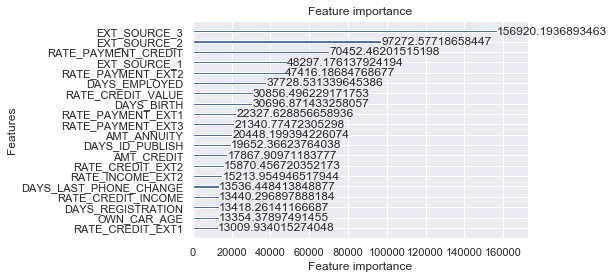

In [51]:
lgb.plot_importance(model, max_num_features=20,importance_type='gain');


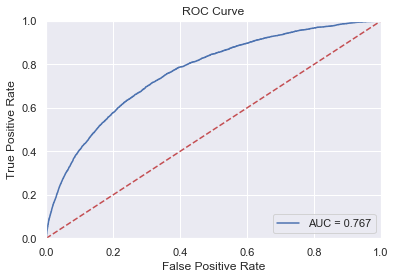

In [52]:
plot_roc_curve(y_xval, y_pred_xval_proba)

In [53]:
%%time

model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    loss_function='CrossEntropy'    
)

model.fit(
    X_train, y_train,
    cat_features=categorical_features,
    eval_set=(X_xval, y_xval),
    verbose=False,
    plot=True
    
)
print('Model is fitted: ' + str(model.is_fitted()))
#print('Model params:')
#print(model.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
CPU times: user 2min 44s, sys: 2.56 s, total: 2min 47s
Wall time: 1min 23s


In [54]:
y_pred_xval_proba = model.predict(X_xval)

thresh = best_f1_thresh(y_xval, y_pred_xval_proba)
# make binary prediction
y_pred_xval = y_pred_xval_proba >= thresh

In [55]:
print("Precision  %.03f" % precision_score(y_xval, y_pred_xval))
print("Recall     %.03f" % recall_score(y_xval, y_pred_xval))
print("F1         %.03f" % f1_score(y_xval, y_pred_xval))
print("Accuracy:  %.03f" % accuracy_score(y_xval, y_pred_xval))
print("AUC        %.03f" % roc_auc_score(y_score=y_pred_xval_proba,y_true=y_xval))

print(confusion_matrix(y_xval, y_pred_xval))

Precision  0.081
Recall     1.000
F1         0.149
Accuracy:  0.081
AUC        0.507
[[    0 56538]
 [    0  4965]]


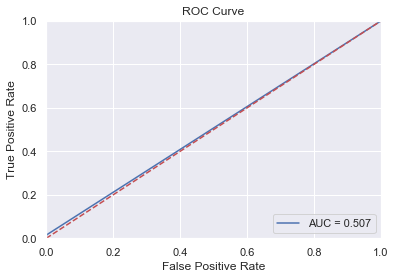

In [56]:
plot_roc_curve(y_xval, y_pred_xval_proba)

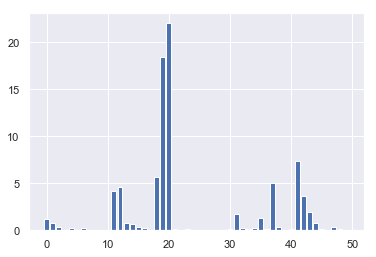

In [57]:
plt.bar(range(howmany), model.feature_importances_[:howmany])
plt.show()

In [58]:
predictor_names = list(data.columns)[1:]
pd.DataFrame(list(zip(predictor_names,model.feature_importances_[:howmany]))).sort_values(1, ascending=False)

,0,1
20,EXT_SOURCE_2,22.030007
19,EXT_SOURCE_1,18.488857
41,RATE_INCOME_EXT3,7.396280
18,ENTRANCES_AVG,5.659188
37,RATE_CREDIT_INCOME,5.038375
12,DAYS_BIRTH,4.628568
11,COMMONAREA_AVG,4.137352
42,RATE_PAYMENT_CREDIT,3.609786
43,RATE_PAYMENT_EXT1,1.995191
31,OBS_60_CNT_SOCIAL_CIRCLE,1.741764


In [59]:
# tune XGBoost

# values tested
max_depths = range(3,15)
subsamples = np.linspace(0.65, 0.9, 6)
colsample_by_trees = np.linspace(0.3, 0.8, 11)
learning_rates = np.logspace(-2, 0, 5)
gammas = [0, 1, 5]

learning_rate = 0.1

# best values found
max_depth = 8
subsample = 0.7
csbt = 0.35
early_stopping_rounds=100
gamma = 5

for gamma in gammas:

    print("#######################################################")
    print("max_depth        %d" % max_depth)
    print("learning_rate    %f" % learning_rate)
    print("subsample        %f" % subsample)
    print("colsample_bytree %f" % csbt)
    print("gamma            %d" % gamma)
    
    print("Start: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))

    model = XGBClassifier(objective='binary:logistic',
                          learning_rate = learning_rate,
                          n_estimators = 30000,
                          early_stopping_rounds=early_stopping_rounds,
                          max_depth= max_depth,
                          subsample = subsample,
                          colsample_bytree = csbt,
                          gamma = gamma,
                          verbose_eval=50                          
                         )
    eval_set = [(X_xval,y_xval)]
    model.fit(X_train, y_train, 
              early_stopping_rounds=early_stopping_rounds,
              eval_metric='auc',
              eval_set=eval_set,
             )
    # predict probability
    y_pred_xval_proba = model.predict_proba(X_xval)[:,1]
    # pick threshold for best f1
    thresh = best_f1_thresh(y_xval, y_pred_xval_proba)
    print(thresh)
    # make binary prediction
    y_pred_xval = y_pred_xval_proba >= thresh

    
    print("End: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))
    
    print("Precision:      %.03f" % precision_score(y_xval, y_pred_xval))
    print("Recall:         %.03f" % recall_score(y_xval, y_pred_xval))
    print("F1:             %.03f" % f1_score(y_xval, y_pred_xval))
    print("Accuracy:       %.03f" % accuracy_score(y_xval, y_pred_xval))
    print("AUC:            %.03f" % roc_auc_score(y_score=y_pred_xval_proba,y_true=y_xval))
    print("#######################################################")
    
    

#######################################################
max_depth        8
learning_rate    0.100000
subsample        0.700000
colsample_bytree 0.350000
gamma            0
Start: Oct 28 2018 13:32:57
[0]	validation_0-auc:0.720595
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.726836
[2]	validation_0-auc:0.730391
[3]	validation_0-auc:0.733205
[4]	validation_0-auc:0.734297
[5]	validation_0-auc:0.736148
[6]	validation_0-auc:0.736462
[7]	validation_0-auc:0.73932
[8]	validation_0-auc:0.739888
[9]	validation_0-auc:0.741122
[10]	validation_0-auc:0.742549
[11]	validation_0-auc:0.743545
[12]	validation_0-auc:0.743322
[13]	validation_0-auc:0.743616
[14]	validation_0-auc:0.743054
[15]	validation_0-auc:0.744488
[16]	validation_0-auc:0.744879
[17]	validation_0-auc:0.74422
[18]	validation_0-auc:0.745261
[19]	validation_0-auc:0.745623
[20]	validation_0-auc:0.74679
[21]	validation_0-auc:0.74659
[22]	validation_0-auc:0.749766
[23]	validation_0-auc:0.751762
[24]	

[32]	validation_0-auc:0.753368
[33]	validation_0-auc:0.755198
[34]	validation_0-auc:0.755508
[35]	validation_0-auc:0.756301
[36]	validation_0-auc:0.756775
[37]	validation_0-auc:0.757673
[38]	validation_0-auc:0.758342
[39]	validation_0-auc:0.758626
[40]	validation_0-auc:0.75846
[41]	validation_0-auc:0.758966
[42]	validation_0-auc:0.75936
[43]	validation_0-auc:0.759524
[44]	validation_0-auc:0.75949
[45]	validation_0-auc:0.759661
[46]	validation_0-auc:0.759339
[47]	validation_0-auc:0.760517
[48]	validation_0-auc:0.760754
[49]	validation_0-auc:0.760866
[50]	validation_0-auc:0.760893
[51]	validation_0-auc:0.761182
[52]	validation_0-auc:0.761308
[53]	validation_0-auc:0.761258
[54]	validation_0-auc:0.761356
[55]	validation_0-auc:0.76201
[56]	validation_0-auc:0.761915
[57]	validation_0-auc:0.762047
[58]	validation_0-auc:0.762078
[59]	validation_0-auc:0.762099
[60]	validation_0-auc:0.762398
[61]	validation_0-auc:0.762594
[62]	validation_0-auc:0.762446
[63]	validation_0-auc:0.762372
[64]	validat

[72]	validation_0-auc:0.765494
[73]	validation_0-auc:0.765718
[74]	validation_0-auc:0.765801
[75]	validation_0-auc:0.76581
[76]	validation_0-auc:0.765804
[77]	validation_0-auc:0.7658
[78]	validation_0-auc:0.765885
[79]	validation_0-auc:0.765646
[80]	validation_0-auc:0.765727
[81]	validation_0-auc:0.765721
[82]	validation_0-auc:0.765646
[83]	validation_0-auc:0.765883
[84]	validation_0-auc:0.766067
[85]	validation_0-auc:0.766059
[86]	validation_0-auc:0.76611
[87]	validation_0-auc:0.766214
[88]	validation_0-auc:0.766315
[89]	validation_0-auc:0.766233
[90]	validation_0-auc:0.766365
[91]	validation_0-auc:0.766366
[92]	validation_0-auc:0.766356
[93]	validation_0-auc:0.7664
[94]	validation_0-auc:0.766314
[95]	validation_0-auc:0.766249
[96]	validation_0-auc:0.766204
[97]	validation_0-auc:0.766451
[98]	validation_0-auc:0.76636
[99]	validation_0-auc:0.766364
[100]	validation_0-auc:0.7666
[101]	validation_0-auc:0.766693
[102]	validation_0-auc:0.76678
[103]	validation_0-auc:0.766856
[104]	validati

In [60]:
# retrain with these hyperparams on all of X
# no xval set, no early stopping
# learning rate 0.01
#
# eval on test

max_depth = 8
subsample = 0.7
csbt = 0.35
learning_rate = 0.01
gamma = 5

# use thresh found previously in xval
thresh = 0.1430786

print("#######################################################")
print("max_depth        %d" % max_depth)
print("learning_rate    %f" % learning_rate)
print("subsample        %f" % subsample)
print("colsample_bytree %f" % csbt)
print("gamma            %d" % gamma)
    
print("Start: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))

model = XGBClassifier(objective='binary:logistic',
                      learning_rate = learning_rate,
                      n_estimators = 2000,
                      max_depth= max_depth,
                      subsample = subsample,
                      colsample_bytree = csbt,
                      gamma = gamma,
                      verbose_eval=50                      

                     )

model.fit(X, y)
# predict probability in X
y_pred_train_proba = model.predict_proba(X)[:,1]
# make binary prediction
y_pred_train = y_pred_train_proba >= thresh

print("End: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))

print("Training Precision:      %.03f" % precision_score(y_xval, y_pred_xval))
print("Training Recall:         %.03f" % recall_score(y_xval, y_pred_xval))
print("Training F1:             %.03f" % f1_score(y_xval, y_pred_xval))
print("Training Accuracy:       %.03f" % accuracy_score(y_xval, y_pred_xval))
print("Training AUC:            %.03f" % roc_auc_score(y_score=y_pred_xval_proba,y_true=y_xval))
print("#######################################################")


#######################################################
max_depth        8
learning_rate    0.010000
subsample        0.700000
colsample_bytree 0.350000
gamma            5
Start: Oct 28 2018 13:57:08
End: Oct 28 2018 15:28:23
Training Precision:      0.247
Training Recall:         0.454
Training F1:             0.320
Training Accuracy:       0.844
Training AUC:            0.769
#######################################################


In [62]:
with open('model1.pickle', 'wb') as file:
    pickle.dump(model, file)


In [65]:
from time import strftime, localtime
print("End: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))


End: Oct 28 2018 16:01:41


In [66]:
test_df = pd.read_pickle("application_test.pickle")
test_df.head()


,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,BASEMENTAREA_AVG,CNT_CHILDREN,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,100001,20560.5,568800.0,135000.0,0.000000,0.000000,0.000000,0.066000,0.059000,0.0,...,1,0,0,0,0,0,0,0,1,0
1,100005,17370.0,222768.0,99000.0,0.000000,0.000000,3.000000,0.118138,0.088673,0.0,...,0,0,1,1,0,0,0,0,0,0
2,100013,69777.0,663264.0,202500.0,0.000000,1.000000,4.000000,0.118138,0.088673,0.0,...,0,0,1,0,1,0,0,0,0,0
3,100028,49018.5,1575000.0,315000.0,0.000000,0.000000,3.000000,0.305200,0.197400,2.0,...,0,0,0,0,0,0,0,0,0,1
4,100038,32067.0,625500.0,180000.0,0.231697,0.304399,1.911564,0.118138,0.088673,1.0,...,0,0,1,1,0,0,0,0,0,0


In [67]:
# predictors : cols 2 to end
X_test = test_df.iloc[:,1:].astype(float)
#X = data.values[:,2:].astype(float)
# response: col 1
y_pred_test_proba = model.predict_proba(data=X_test)[:,1]



In [72]:
csvframe = pd.DataFrame(
    {'SK_ID_CURR' : test_df['SK_ID_CURR'],
     'TARGET': y_pred_test_proba
    }
)
csvframe.to_csv("kaggle.csv",index=False)

csvframe.head()
# kaggle competitions submit -c home-credit-default-risk -f kaggle.csv -m "Baseline 2"
# public leaderboard 0.76742
# similar score so I probably didn't totally screw up test/train
# 4636 / 7198 


,SK_ID_CURR,TARGET
0,100001,0.033739
1,100005,0.085279
2,100013,0.019629
3,100028,0.034732
4,100038,0.133188
5,100042,0.039189
6,100057,0.011537
7,100065,0.052814
8,100066,0.012186
9,100067,0.073922
